### EDA y GEDA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns
from scipy import stats

In [2]:
df = pd.read_csv('/Volumes/MemoriaEle/HeavyData/incidentes-viales-c5.csv')

In [3]:
df.shape

(1383138, 18)

In [4]:
df.head()

,folio,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,fecha_cierre,año_cierre,mes_cierre,hora_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,geopoint,mes
0,GA/160123/05714,23/01/2016,22:35:04,Sábado,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,00:21:08,VENUSTIANO CARRANZA,accidente-choque sin lesionados,19.422113,-99.084643,EMERGENCIA,BOTÓN DE AUXILIO,VENUSTIANO CARRANZA,"19.422113,-99.084643",1
1,AO/160123/05826,23/01/2016,22:50:49,Sábado,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,04:40:37,CUAJIMALPA,accidente-choque con lesionados,19.358320,-99.297641,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,CUAJIMALPA,"19.35832,-99.297641",1
2,C4/160124/02187,24/01/2016,09:40:11,Domingo,(N) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,11:13:03,TLALPAN,accidente-choque sin lesionados,19.217070,-99.219070,EMERGENCIA,LLAMADA DEL 066,TLALPAN,"19.21707,-99.21907008",1
3,C4/160124/05723,24/01/2016,22:40:57,Domingo,(N) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,22:55:51,MAGDALENA CONTRERAS,accidente-choque sin lesionados,19.320580,-99.241010,EMERGENCIA,LLAMADA DEL 066,MAGDALENA CONTRERAS,"19.32057999,-99.24100992",1
4,C4/160124/01334,24/01/2016,04:25:15,Domingo,(A) La unidad de atención a emergencias fue de...,24/01/2016,2016,Enero,05:03:59,MIGUEL HIDALGO,accidente-choque sin lesionados,19.452900,-99.215870,EMERGENCIA,LLAMADA DEL 066,MIGUEL HIDALGO,"19.45289997,-99.21587004",1


In [5]:
df.nunique()

folio                1383138
fecha_creacion          2637
hora_creacion         105887
dia_semana                 7
codigo_cierre              5
fecha_cierre            2621
año_cierre                 7
mes_cierre                12
hora_cierre           106827
delegacion_inicio         16
incidente_c4              26
latitud                82501
longitud               78984
clas_con_f_alarma          4
tipo_entrada               9
delegacion_cierre         16
geopoint              134288
mes                       12
dtype: int64

In [6]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = df.select_dtypes(include=numerics)
newdf.shape[1]

4

In [7]:
df.dtypes

folio                 object
fecha_creacion        object
hora_creacion         object
dia_semana            object
codigo_cierre         object
fecha_cierre          object
año_cierre             int64
mes_cierre            object
hora_cierre           object
delegacion_inicio     object
incidente_c4          object
latitud              float64
longitud             float64
clas_con_f_alarma     object
tipo_entrada          object
delegacion_cierre     object
geopoint              object
mes                    int64
dtype: object

In [14]:
date_df = df.select_dtypes(include='datetime')
date_df.shape[1]

0

In [10]:
df.dia_semana.unique()

array(['Sábado', 'Domingo', 'Lunes', 'Martes', 'Miércoles', 'Jueves',
       'Viernes'], dtype=object)

In [12]:
df.año_cierre.unique()

array([2016, 2017, 2018, 2019, 2015, 2014, 2020])

In [13]:
df.mes_cierre.unique()

array(['Enero', 'Febrero', 'Marzo', 'Septiembre', 'Octubre', 'Mayo',
       'Junio', 'Abril', 'Agosto', 'Diciembre', 'Julio', 'Noviembre'],
      dtype=object)

In [15]:
df.hora_cierre.nunique()

106827

In [16]:
df.delegacion_inicio.nunique()

16

In [17]:
df.incidente_c4.unique()

array(['accidente-choque sin lesionados',
       'accidente-choque con lesionados',
       'lesionado-accidente automovilístico', 'accidente-volcadura',
       'lesionado-atropellado', 'accidente-otros',
       'accidente-persona atrapada / desbarrancada',
       'cadáver-accidente automovilístico', 'cadáver-atropellado',
       'accidente-motociclista', 'accidente-vehiculo desbarrancado',
       'accidente-choque con prensados', 'accidente-vehiculo atrapado',
       'accidente-ciclista', 'accidente-monopatín',
       'sismo-choque con lesionados',
       'accidente-vehículo atrapado-varado',
       'detención ciudadana-atropellado', 'accidente-ferroviario',
       'detención ciudadana-accidente automovilístico',
       'sismo-choque sin lesionados', 'sismo-persona atropellada',
       'Detención ciudadana-accidente automovilístico',
       'sismo-choque con prensados',
       'mi ciudad-calle-incidente de tránsito',
       'mi ciudad-taxi-incidente de tránsito'], dtype=object)

In [18]:
df.clas_con_f_alarma.unique()

array(['EMERGENCIA', 'URGENCIAS MEDICAS', 'FALSA ALARMA', 'DELITO'],
      dtype=object)

In [19]:
df.tipo_entrada.unique()

array(['BOTÓN DE AUXILIO', 'LLAMADA DEL 066', 'RADIO', 'CÁMARA', 'REDES',
       'LLAMADA DEL 911', 'LLAMADA APP911', 'ZELLO', 'APLICATIVOS'],
      dtype=object)

In [20]:
df.codigo_cierre.unique()

array(['(A) La unidad de atención a emergencias fue despachada, llegó al lugar de los hechos y confirmó la emergencia reportada',
       '(N) La unidad de atención a emergencias fue despachada, llegó al lugar de los hechos, pero en el sitio del evento nadie solicitó el apoyo de la unidad',
       '(D) El incidente reportado se registró en dos o más ocasiones procediendo a mantener un único reporte (afirmativo, informativo, negativo o falso) como el identificador para el incidente',
       '(F) El operador/a o despachador/a identifican, antes de dar respuesta a la emergencia, que ésta es falsa. O al ser despachada una unidad de atención a emergencias en el lugar de los hechos se percatan que el incidente no corresponde al reportado inicialmente',
       '(I) El incidente reportado es afirmativo y se añade información adicional al evento'],
      dtype=object)

In [26]:
df.codigo_cierre.nunique()

5

In [27]:
df.mes.unique()

array([ 1,  2,  3,  9, 10,  5,  6,  4,  8, 12,  7, 11])

In [22]:
df.describe()

,año_cierre,latitud,longitud,mes
count,1.383138e+06,1.382695e+06,1.382703e+06,1.383138e+06
mean,2.017023e+03,1.938391e+01,-9.914359e+01,6.617056e+00
std,1.869989e+00,2.666382e-01,2.399677e+00,3.460213e+00
min,2.014000e+03,1.909402e+01,-9.917640e+02,1.000000e+00
25%,2.015000e+03,1.933685e+01,-9.917930e+01,4.000000e+00
50%,2.017000e+03,1.938408e+01,-9.914023e+01,7.000000e+00
75%,2.019000e+03,1.943496e+01,-9.909600e+01,1.000000e+01
max,2.020000e+03,1.953030e+02,-9.894537e+01,1.200000e+01


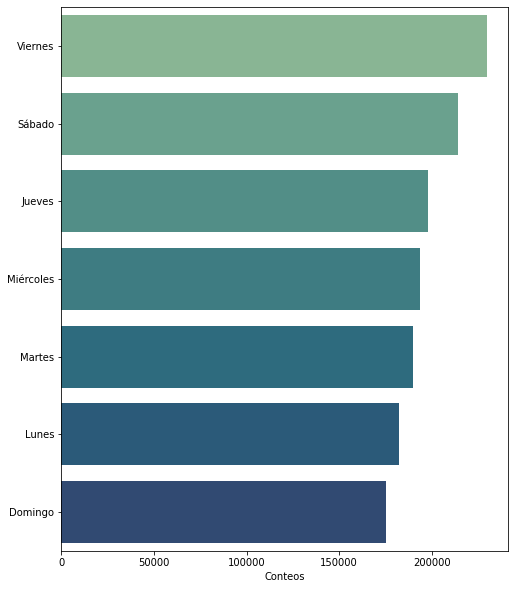

In [23]:
plt.figure(figsize=(8,10))
ax = sns.barplot(x=df.dia_semana.value_counts(), 
                 y=df.dia_semana.value_counts().index, data=df,           
                palette='crest')
ax.set(xlabel='Conteos')
plt.show()

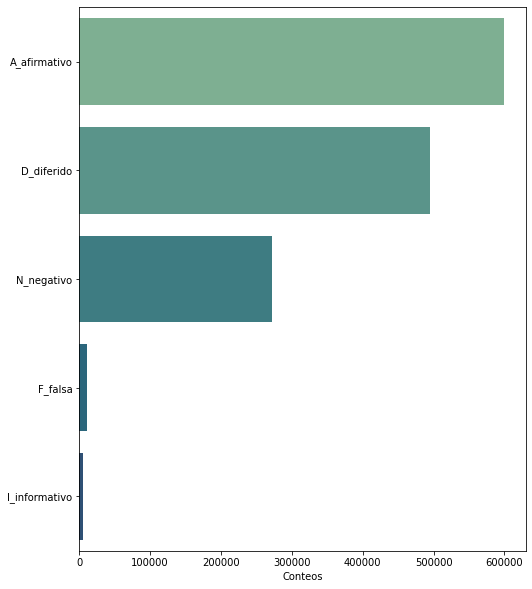

In [33]:
plt.figure(figsize=(8,10))
ax = sns.barplot(x=df.codigo_cierre.value_counts(), 
                 y=df.codigo_cierre.value_counts().index, data=df,           
                palette='crest')
ax.set(xlabel='Conteos')
plt.show()

In [31]:
df = df.replace({'(A) La unidad de atención a emergencias fue despachada, llegó al lugar de los hechos y confirmó la emergencia reportada':'A_afirmativo',
                          '(N) La unidad de atención a emergencias fue despachada, llegó al lugar de los hechos, pero en el sitio del evento nadie solicitó el apoyo de la unidad': 'N_negativo',
                          '(D) El incidente reportado se registró en dos o más ocasiones procediendo a mantener un único reporte (afirmativo, informativo, negativo o falso) como el identificador para el incidente':'D_diferido',
                         '(F) El operador/a o despachador/a identifican, antes de dar respuesta a la emergencia, que ésta es falsa. O al ser despachada una unidad de atención a emergencias en el lugar de los hechos se percatan que el incidente no corresponde al reportado inicialmente':'F_falsa',
                          '(I) El incidente reportado es afirmativo y se añade información adicional al evento': 'I_informativo'})

In [32]:
df.head()

,folio,fecha_creacion,hora_creacion,dia_semana,codigo_cierre,fecha_cierre,año_cierre,mes_cierre,hora_cierre,delegacion_inicio,incidente_c4,latitud,longitud,clas_con_f_alarma,tipo_entrada,delegacion_cierre,geopoint,mes
0,GA/160123/05714,23/01/2016,22:35:04,Sábado,A_afirmativo,24/01/2016,2016,Enero,00:21:08,VENUSTIANO CARRANZA,accidente-choque sin lesionados,19.422113,-99.084643,EMERGENCIA,BOTÓN DE AUXILIO,VENUSTIANO CARRANZA,"19.422113,-99.084643",1
1,AO/160123/05826,23/01/2016,22:50:49,Sábado,A_afirmativo,24/01/2016,2016,Enero,04:40:37,CUAJIMALPA,accidente-choque con lesionados,19.358320,-99.297641,URGENCIAS MEDICAS,BOTÓN DE AUXILIO,CUAJIMALPA,"19.35832,-99.297641",1
2,C4/160124/02187,24/01/2016,09:40:11,Domingo,N_negativo,24/01/2016,2016,Enero,11:13:03,TLALPAN,accidente-choque sin lesionados,19.217070,-99.219070,EMERGENCIA,LLAMADA DEL 066,TLALPAN,"19.21707,-99.21907008",1
3,C4/160124/05723,24/01/2016,22:40:57,Domingo,N_negativo,24/01/2016,2016,Enero,22:55:51,MAGDALENA CONTRERAS,accidente-choque sin lesionados,19.320580,-99.241010,EMERGENCIA,LLAMADA DEL 066,MAGDALENA CONTRERAS,"19.32057999,-99.24100992",1
4,C4/160124/01334,24/01/2016,04:25:15,Domingo,A_afirmativo,24/01/2016,2016,Enero,05:03:59,MIGUEL HIDALGO,accidente-choque sin lesionados,19.452900,-99.215870,EMERGENCIA,LLAMADA DEL 066,MIGUEL HIDALGO,"19.45289997,-99.21587004",1


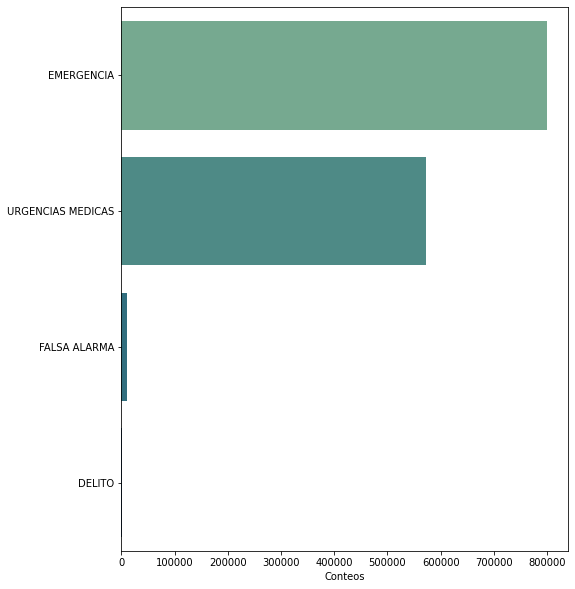

In [34]:
plt.figure(figsize=(8,10))
ax = sns.barplot(x=df.clas_con_f_alarma.value_counts(), 
                 y=df.clas_con_f_alarma.value_counts().index, data=df,           
                palette='crest')
ax.set(xlabel='Conteos')
plt.show()

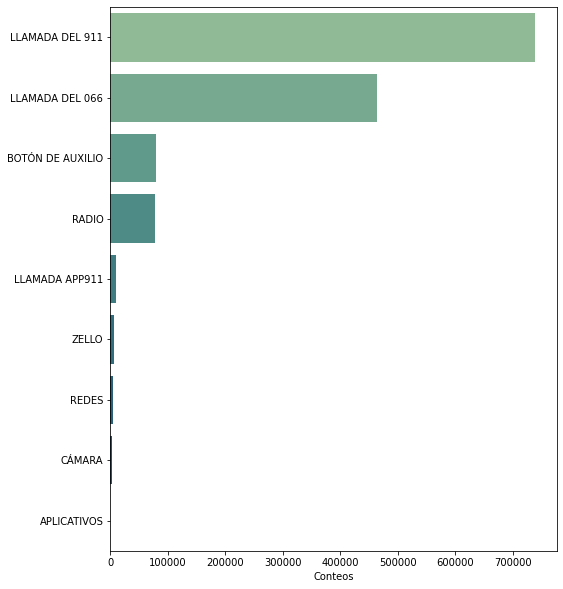

In [35]:
plt.figure(figsize=(8,10))
ax = sns.barplot(x=df.tipo_entrada.value_counts(), 
                 y=df.tipo_entrada.value_counts().index, data=df,           
                palette='crest')
ax.set(xlabel='Conteos')
plt.show()

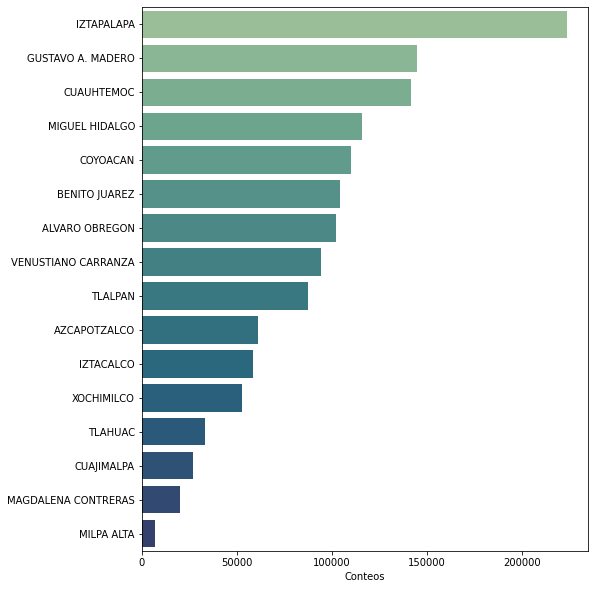

In [39]:
plt.figure(figsize=(8,10))
ax = sns.barplot(x=df.delegacion_inicio.value_counts(), 
                 y=df.delegacion_inicio.value_counts().index, data=df,           
                palette='crest')
ax.set(xlabel='Conteos')
plt.show()

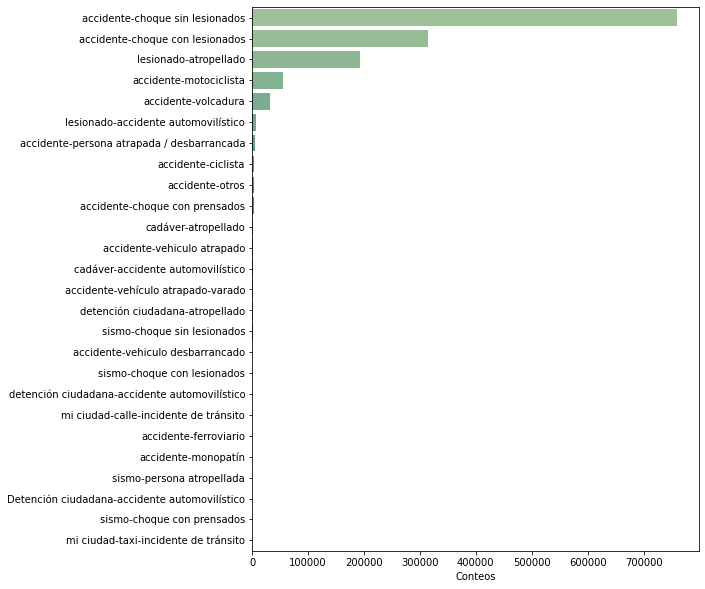

In [40]:
plt.figure(figsize=(8,10))
ax = sns.barplot(x=df.incidente_c4.value_counts(), 
                 y=df.incidente_c4.value_counts().index, data=df,           
                palette='crest')
ax.set(xlabel='Conteos')
plt.show()

In [41]:
df.incidente_c4.value_counts()

accidente-choque sin lesionados                  760506
accidente-choque con lesionados                  315031
lesionado-atropellado                            193553
accidente-motociclista                            55646
accidente-volcadura                               31766
lesionado-accidente automovilístico                6054
accidente-persona atrapada / desbarrancada         5607
accidente-ciclista                                 2718
accidente-otros                                    2465
accidente-choque con prensados                     2334
cadáver-atropellado                                1975
accidente-vehiculo atrapado                        1121
cadáver-accidente automovilístico                  1083
accidente-vehículo atrapado-varado                  852
detención ciudadana-atropellado                     702
sismo-choque sin lesionados                         540
accidente-vehiculo desbarrancado                    490
sismo-choque con lesionados                     